**Objectif :** L'objectif de ce notebook est d'appliquer des méthodes de dé-bruitage d'images et pre-traitement des valeurs manquantes.
A partir de la librairie Sckit-Learn on va trouver les algorithmes suivants :

- Inpainting NS
- Inpainting TELEA

**Travail :**






# Install packages

In [3]:
# !pip install wget

In [ ]:
# ! pip3 install opencv-contrib-python

In [ ]:
# ! apt-get install ffmpeg libsm6 libxext6  -y

In [ ]:
# ! pip3 install scikit-image

In [119]:
# ! pip3 install shap==0.39.0

# Import packages

In [3]:
import wget
import numpy as np
import tifffile as tiff
from matplotlib import pyplot as plt
import cv2
import random
from sklearn.impute import SimpleImputer
from os.path import join
from osgeo import gdal, gdal_array, osr, ogr
from skimage.segmentation import felzenszwalb, mark_boundaries
from sklearn.cluster import MiniBatchKMeans
from sklearn.model_selection import train_test_split
import pprint
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, balanced_accuracy_score
import shap 

# from utils import stretch_train, array2raster
# %matplotlib notebook

# Import data

---

🚨 ❗L'importation des données prend environ 1 minute ❗

---

In [5]:
url3='https://ecoles-projets-shared-files.hupi.io/satellite/USE_CASE_2.zip'
wget.download(url3)

'USE_CASE_2.zip'

In [12]:
!unzip USE_CASE_2.zip

Archive:  USE_CASE_2.zip
   creating: USE_CASE_2/
   creating: USE_CASE_2/dossier_modelisation/
   creating: USE_CASE_2/dossier_modelisation/reconstructed_stats/
  inflating: USE_CASE_2/dossier_modelisation/reconstructed_stats/T31TCJ_median_ndvi.prj  
  inflating: USE_CASE_2/dossier_modelisation/reconstructed_stats/T31TCJ_median_ndvi.shx  
  inflating: USE_CASE_2/dossier_modelisation/reconstructed_stats/T31TCJ_median_ndvi.cpg  
  inflating: USE_CASE_2/dossier_modelisation/reconstructed_stats/T31TCJ_median_ndvi.shp  
  inflating: USE_CASE_2/dossier_modelisation/reconstructed_stats/T31TCJ_median_ndvi.dbf  
   creating: USE_CASE_2/dossier_modelisation/pixel_classification/
  inflating: USE_CASE_2/dossier_modelisation/pixel_classification/pixel_classification.tif  
   creating: USE_CASE_2/image_dataset/
   creating: USE_CASE_2/image_dataset/stacked_bands_sicoval/
  inflating: USE_CASE_2/image_dataset/stacked_bands_sicoval/T31TCJ_20190725T105031_stacked_masked_cropped.tif.aux.xml  
  inflat

In [7]:
ls

sample_data/  USE_CASE_2.zip


# Image Data Inspection and Visualization

L'objectif est d'inspecter et de visualiser le jeu de données d'images résultant de l'étape de prétraitement précédent.

# Functions definition

- ## Fonction `stretch_train` pour normaliser les données d'entrées dans l'intervalle [0,1]
- ## Fonction `array2raster` pour sauvegarder un raster géoréférencé
- ## Fonction `create_directory` pour créer un répertoire

In [8]:
def stretch_train(bands, lower_percent=2, higher_percent=98):
    out = np.zeros_like(bands, dtype=np.float32)
    n = bands.shape[len(bands.shape)-1]
    C,D = [],[]
    for i in range(n):
        a = 0
        b = 1
        tmp = bands[...,i]
        tmp = tmp[~np.isnan(tmp)]
        c = np.percentile(tmp, lower_percent)
        C.append(c)
        d = np.percentile(tmp, higher_percent)
        D.append(d)
        t = a + (bands[..., i] - c) * (b - a) / (d - c)
        t[t < a] = a
        t[t > b] = b
        out[..., i] = t
    return out.astype(np.float32), C, D
    
def array2raster(newRasterfn, dataset, array, dtype):
    cols = array.shape[1]
    rows = array.shape[0]
    originX, pixelWidth, b, originY, d, pixelHeight = dataset.GetGeoTransform()
    driver = gdal.GetDriverByName('GTiff')
    GDT_dtype = gdal.GDT_Unknown
    if dtype == "Byte":
        GDT_dtype = gdal.GDT_Byte
    elif dtype == "Float32":
        GDT_dtype = gdal.GDT_Float32
    else:
        print("Not supported data type.")
    if array.ndim == 2:
        band_num = 1
    else:
        band_num = array.shape[2]

    outRaster = driver.Create(newRasterfn, cols, rows, band_num, GDT_dtype)
    outRaster.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))
    for b in range(band_num):
        outband = outRaster.GetRasterBand(b + 1)
        if band_num == 1:
            outband.WriteArray(array)
        else:
            outband.WriteArray(array[:,:,b])

    prj=dataset.GetProjection()
    outRasterSRS = osr.SpatialReference(wkt=prj)
    outRaster.SetProjection(outRasterSRS.ExportToWkt())
    outband.FlushCache()

def create_directory(folder_name):
    if not os.path.exists(folder_name):
        try:
            os.mkdir(folder_name)
        except OSError as exc:
            if exc.errno!=errno.EEXIST:
                raise

# Path definition 

On définit le chemin des deux images que nous allons étudier et le raster pour l'entraînement contenant les étiquettes (labels).

In [9]:
img1_path = './USE_CASE_2/image_dataset/stacked_bands_sicoval/T31TCJ_20190327T105031_stacked_masked_cropped.tif'
img2_path = './USE_CASE_2/image_dataset/stacked_bands_sicoval/T31TCJ_20190725T105031_stacked_masked_cropped.tif'

training_path = './USE_CASE_2/image_dataset/training_data/sicoval_training.tif'
training_folder = './USE_CASE_2/image_dataset/training_data' 

img1_path_inpaint = './USE_CASE_2/image_dataset/training_data/inpainted_img1.tif'
img2_path_inpaint = './USE_CASE_2/image_dataset/training_data/inpainted_img2.tif'

# Prétraitement n°1 : visualisations et prétraitements des images

## Visualisation d'une image

(1967, 2520, 4)


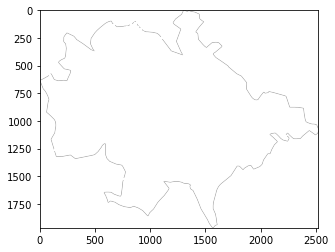

In [15]:
img1 = tiff.imread(img1_path)
print(img1.shape)
plt.figure(1)
plt.imshow(img1)

In [16]:
np.unique(img1, return_counts=True)

(array([0.0000e+00, 1.0000e+00, 9.0000e+00, ..., 1.3752e+04, 1.7680e+04,
               nan], dtype=float32),
 array([9840036,      14,       1, ...,       1,       1,    8976]))

## Recherche des valeurs abérrantes

Les valeurs supérieures à 10 000 sont des outliers car le maximum des valeurs réelles exploitables est 10 000.

In [17]:
np.max(img1[~np.isnan(img1)]) # it's an outlier

17680.0

## Prétraitement n°1 : normalisation avec la fonction `stretch_train`

Normaliser l'image en utilisant le 2ème quantile comme minimum et le 98ème quantile comme le maximum, ceci afin de filtrer le minimum et maximum qui sont des valeurs abérrantes. Puis visualiser l'image avec la transformation.

**N.B.:** Notez que la quatrième bande (NIR) agit comme une bande alpha dans matplotlib.

Remarque : les bandes de couleurs sont de 0 à 2 (blue, green, red), puis la dernière bande n°3 est celle associé à la bande spectrale proche infrarouge.

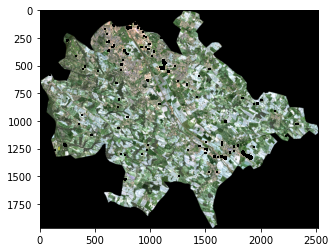

In [18]:
norm_img1,_,_ = stretch_train(img1)
plt.figure(2)
plt.imshow(norm_img1[...,0:3])

In [19]:
np.max(norm_img1[~np.isnan(norm_img1)]) # la valeur aberrante a été supprimée

1.0

On fait de même avec la seconde image.

(1967, 2520, 4)


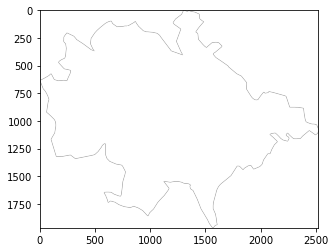

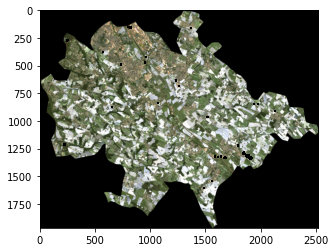

In [20]:
img2 = tiff.imread(img2_path)
print(img2.shape)
plt.figure(3)
plt.imshow(img2)

norm_img2,_,_ = stretch_train(img2)
plt.figure(4)
plt.imshow(norm_img2[...,0:3])

## Visualiser les images labellisées

Dans ce cadre de travail, les étiquettes représentent la culture de certaines parcelles agricoles. Nous avons d'abord transformé le fichier vectoriel `.shapefile` en un fichier de type `raster`.

(1967, 2520)


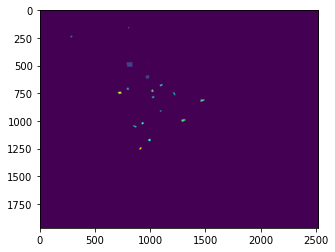

In [21]:
img_train = tiff.imread(training_path)
print(img_train.shape)
plt.figure(5)
plt.imshow(img_train)

## 🌴 Analyse 1 : superposer les images avec les labels
---

Peut-on superposer les étiquettes sur l'une des deux images en utilisant matplotlib ?

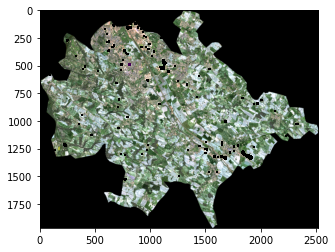

In [22]:
copy_train = np.copy(img_train).astype(float)
copy_train[copy_train==0] = np.nan

plt.figure(6)
plt.imshow(norm_img1[...,0:3]) # ou norm_img2
plt.imshow(copy_train)

# Prétraitement n°2 : traitement des valeurs manquantes 

Voici quelques méthodes possibles pour le traitement des valeurs manquantes dans des images : 

1. `Inpainting methods` : Une façon de traiter les données manquantes est d'utiliser des méthodes d'inpainting. Ces méthodes visent à remplacer les valeurs manquantes en utilisant le contexte des pixels voisins dans l'image.

2. `Imputation and interpolation methods` : L'image elle-même peut être transformée en un tableau 2D et les données peuvent êtr imputées en utilisant des méthodes d'imputation ou d'interpolation.

3. `KNN method` : L'algorithme KNN (N-nearest neighbors) serait envisageable aussi à condition d'avoir suffisamment d'images dans le temps et ainsi remplacer les valeurs manquantes selon leur même position mais analysées dans le temps. Dans notre cas pratique il n'y a que deux dates et la distance ne sera pas fiable.

## 🌴 Analyse 2 : les méthodes d'inpainting
---

Nous allons utiliser la librairie Python `opencv` afin d'appliquer, tester et comparer 2 méthodes : 

- `INPAINT NS` : la marche rapide depuis la limite d’une région vers l’intérieur, à l’aide de voisinage, on remplace le pixel manquant par la somme pondérée normalisée de tous les pixels connus dans le voisinage

- `INPAINT TELEA` : basée sur la dynamique des fluides et des équations différentielles partielles. Il parcourt d'abord les bords des régions connues vers les régions inconnues. Il poursuit les isophotes (lignes joignant des points de même intensité, tout comme les contours joignent des points de même élévation) tout en faisant correspondre les vecteurs de gradient à la limite de la région à re-peindre. Puis, la couleur est remplie pour réduire la variance minimale dans cette zone

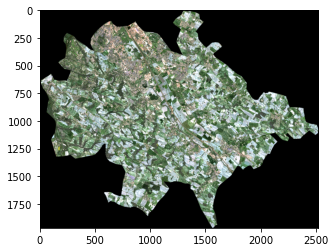

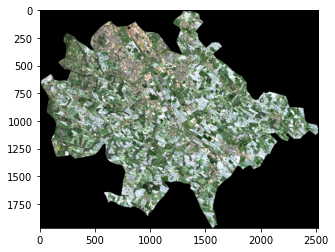

In [23]:
inpaint1_arr1 = np.zeros_like(norm_img1)
mask = np.isnan(norm_img1).astype(np.uint8)
inpaint1_arr1[...,0] = cv2.inpaint(norm_img1[...,0], mask[...,0],5, cv2.INPAINT_NS)
inpaint1_arr1[...,1] = cv2.inpaint(norm_img1[...,1], mask[...,0],5, cv2.INPAINT_NS)
inpaint1_arr1[...,2] = cv2.inpaint(norm_img1[...,2], mask[...,0],5, cv2.INPAINT_NS)
inpaint1_arr1[...,3] = cv2.inpaint(norm_img1[...,0], mask[...,3],5, cv2.INPAINT_NS)
plt.figure(7)
plt.imshow(inpaint1_arr1[...,0:3])

inpaint1_arr2 = np.zeros_like(norm_img1)
mask = np.isnan(norm_img1).astype(np.uint8)
inpaint1_arr2[...,0] = cv2.inpaint(norm_img1[...,0], mask[...,0],5, cv2.INPAINT_TELEA)
inpaint1_arr2[...,1] = cv2.inpaint(norm_img1[...,1], mask[...,0],5, cv2.INPAINT_TELEA)
inpaint1_arr2[...,2] = cv2.inpaint(norm_img1[...,2], mask[...,0],5, cv2.INPAINT_TELEA)
inpaint1_arr2[...,3] = cv2.inpaint(norm_img1[...,0], mask[...,3],5, cv2.INPAINT_TELEA)
plt.figure(8)
plt.imshow(inpaint1_arr2[...,0:3])

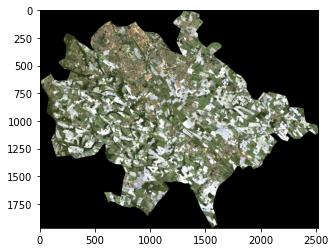

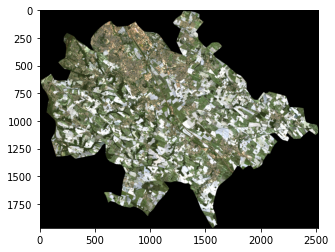

In [24]:
inpaint2_arr1 = np.zeros_like(norm_img2)
mask = np.isnan(norm_img2).astype(np.uint8)
inpaint2_arr1[...,0] = cv2.inpaint(norm_img2[...,0], mask[...,0],5, cv2.INPAINT_NS)
inpaint2_arr1[...,1] = cv2.inpaint(norm_img2[...,1], mask[...,0],5, cv2.INPAINT_NS)
inpaint2_arr1[...,2] = cv2.inpaint(norm_img2[...,2], mask[...,0],5, cv2.INPAINT_NS)
inpaint2_arr1[...,3] = cv2.inpaint(norm_img2[...,0], mask[...,3],5, cv2.INPAINT_NS)
plt.figure(9)
plt.imshow(inpaint2_arr1[...,0:3])

inpaint2_arr2 = np.zeros_like(norm_img2)
mask = np.isnan(norm_img2).astype(np.uint8)
inpaint2_arr2[...,0] = cv2.inpaint(norm_img2[...,0], mask[...,0],5, cv2.INPAINT_TELEA)
inpaint2_arr2[...,1] = cv2.inpaint(norm_img2[...,1], mask[...,0],5, cv2.INPAINT_TELEA)
inpaint2_arr2[...,2] = cv2.inpaint(norm_img2[...,2], mask[...,0],5, cv2.INPAINT_TELEA)
inpaint2_arr2[...,3] = cv2.inpaint(norm_img2[...,0], mask[...,3],5, cv2.INPAINT_TELEA)
plt.figure(10)
plt.imshow(inpaint2_arr2[...,0:3])

## 🖍 Exercice 1 : Comparer les résultats
---

Après avoir identifier les pixels contenant des valeurs manquantes, comparer les 2 méthodes de reconstruction d'images.

In [24]:
## A vous de jouer !

Correction : une idée de recherche simple

In [25]:
image = norm_img1.copy()
random_rows = [random.randint(0, random.randint(0,int(len(np.argwhere(np.isnan(image)))))) for i in range(10)]

for i in random_rows:
  index_to_test = np.argwhere(np.isnan(image))[i]
  print('na value :', norm_img1[index_to_test[0], index_to_test[1], index_to_test[2]])
  print('Inpainting NS method result :', inpaint1_arr1[index_to_test[0], index_to_test[1], index_to_test[2]])
  print('Inpainting TELEA method result :', inpaint1_arr2[index_to_test[0], index_to_test[1], index_to_test[2]])
  print('')

na value : nan
Inpainting NS method result : 0.6915493
Inpainting TELEA method result : 1.9795958

na value : nan
Inpainting NS method result : 0.8589406
Inpainting TELEA method result : 0.26121238

na value : nan
Inpainting NS method result : 0.82951427
Inpainting TELEA method result : 2.456185

na value : nan
Inpainting NS method result : 0.76796275
Inpainting TELEA method result : 0.1969704

na value : nan
Inpainting NS method result : 0.87927145
Inpainting TELEA method result : 0.15436555

na value : nan
Inpainting NS method result : 0.76692677
Inpainting TELEA method result : 1.5414845

na value : nan
Inpainting NS method result : 0.15724729
Inpainting TELEA method result : 0.14536095

na value : nan
Inpainting NS method result : 0.7857126
Inpainting TELEA method result : 0.8780512

na value : nan
Inpainting NS method result : 0.83737296
Inpainting TELEA method result : 0.2968872

na value : nan
Inpainting NS method result : 0.9512958
Inpainting TELEA method result : 1.3687714



## 🌴 Analyse 3 : les méthodes d'imputation
---

Essayons l'imputation avec la valeur moyenne sur la bande spectrale.

(1967, 2520, 4)
(4956840, 4)
(1967, 2520, 4)
(4956840, 4)


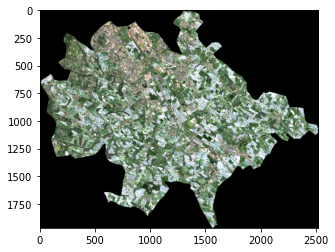

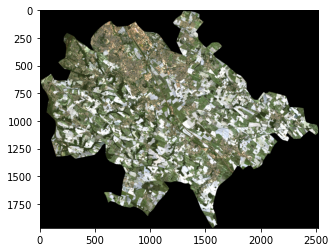

In [26]:
imputed_arr1 = np.copy(norm_img1)
print(imputed_arr1.shape)
imputed_arr1 = np.reshape(imputed_arr1,(imputed_arr1.shape[0]*imputed_arr1.shape[1],imputed_arr1.shape[2]))
print(imputed_arr1.shape)
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imputed_arr1 = imp.fit_transform(imputed_arr1)
imputed_arr1 = np.reshape(imputed_arr1,norm_img1.shape)
plt.figure(11)
plt.imshow(imputed_arr1[...,0:3])

imputed_arr2 = np.copy(norm_img2)
print (imputed_arr2.shape)
imputed_arr2 = np.reshape(imputed_arr2,(imputed_arr2.shape[0]*imputed_arr2.shape[1],imputed_arr2.shape[2]))
print (imputed_arr2.shape)
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imputed_arr2 = imp.fit_transform(imputed_arr2)
imputed_arr2 = np.reshape(imputed_arr2,norm_img2.shape)
plt.figure(12)
plt.imshow(imputed_arr2[...,0:3])

## 🖍 Exercice 2 : Comparer les résultats
---

Après avoir identifier les pixels contenant des valeurs manquantes, comparer les 2 méthodes de reconstruction d'images et la méthode d'imputation par la moyenne sur toute la bande spectrale.

In [26]:
## A vous de jouer !

Correction :

In [27]:
image = norm_img1.copy()
random_rows = [random.randint(0, random.randint(0,int(len(np.argwhere(np.isnan(image)))))) for i in range(10)]

for i in random_rows:
  index_to_test = np.argwhere(np.isnan(image))[i]
  print('na value :', norm_img1[index_to_test[0], index_to_test[1], index_to_test[2]])
  print('Inpainting NS method result :', inpaint1_arr1[index_to_test[0], index_to_test[1], index_to_test[2]])
  print('Inpainting TELEA method result :', inpaint1_arr2[index_to_test[0], index_to_test[1], index_to_test[2]])
  print('Imputation result :', imputed_arr1[index_to_test[0], index_to_test[1], index_to_test[2]])
  print('')

na value : nan
Inpainting NS method result : 0.8940919
Inpainting TELEA method result : 0.6150882
Imputation result : 0.2554801

na value : nan
Inpainting NS method result : 0.8058217
Inpainting TELEA method result : 0.6434893
Imputation result : 0.2554801

na value : nan
Inpainting NS method result : 0.9431857
Inpainting TELEA method result : 1.7417006
Imputation result : 0.2554801

na value : nan
Inpainting NS method result : 0.95783645
Inpainting TELEA method result : 0.121726036
Imputation result : 0.25973642

na value : nan
Inpainting NS method result : 0.44926676
Inpainting TELEA method result : -0.4576985
Imputation result : 0.25973642

na value : nan
Inpainting NS method result : 0.25671938
Inpainting TELEA method result : 1.6946856
Imputation result : 0.25973642

na value : nan
Inpainting NS method result : 0.8943874
Inpainting TELEA method result : 0.004522923
Imputation result : 0.29515344

na value : nan
Inpainting NS method result : 0.76692677
Inpainting TELEA method resul

In [28]:
image = norm_img2.copy()
random_rows = [random.randint(0, random.randint(0,int(len(np.argwhere(np.isnan(image)))))) for i in range(10)]

for i in random_rows:
  index_to_test = np.argwhere(np.isnan(image))[i]
  print('na value :', norm_img2[index_to_test[0], index_to_test[1], index_to_test[2]])
  print('Inpainting NS method result :', inpaint2_arr1[index_to_test[0], index_to_test[1], index_to_test[2]])
  print('Inpainting TELEA method result :', inpaint2_arr2[index_to_test[0], index_to_test[1], index_to_test[2]])
  print('Imputation result :', imputed_arr2[index_to_test[0], index_to_test[1], index_to_test[2]])
  print('')

na value : nan
Inpainting NS method result : 0.67406964
Inpainting TELEA method result : 0.07859092
Imputation result : 0.26638162

na value : nan
Inpainting NS method result : 0.9906903
Inpainting TELEA method result : 0.7621563
Imputation result : 0.26638162

na value : nan
Inpainting NS method result : 0.9816228
Inpainting TELEA method result : 1.1234013
Imputation result : 0.38017327

na value : nan
Inpainting NS method result : 0.95205206
Inpainting TELEA method result : 0.14295611
Imputation result : 0.26638162

na value : nan
Inpainting NS method result : 0.6996402
Inpainting TELEA method result : 0.23922376
Imputation result : 0.26638162

na value : nan
Inpainting NS method result : 0.28107086
Inpainting TELEA method result : -0.23556088
Imputation result : 0.2795121

na value : nan
Inpainting NS method result : 0.2601404
Inpainting TELEA method result : 0.8487868
Imputation result : 0.38017327

na value : nan
Inpainting NS method result : 0.15765631
Inpainting TELEA method res

## Sauvegarder les images

On sauvegarde les images après avoir appliqué les transformations pour reconstruire les images.

In [29]:
inpainted_img1_path = join(training_folder,'inpainted_img1.tif')
inpainted_img2_path = join(training_folder,'inpainted_img2.tif')

# La meilleur methode etait avec INPAINT_NS
# Puis on sauvegarde les images avec la fonction array2raster
dataset = gdal.Open(img1_path)
array2raster(inpainted_img1_path,dataset,inpaint1_arr1,'Float32')

dataset = gdal.Open(img2_path)
array2raster(inpainted_img2_path,dataset,inpaint2_arr1,'Float32')

In [30]:
ls -altr ./USE_CASE_2/image_dataset/training_data/

total 314712
-rw-r--r-- 1 root root  4963656 May 20  2021 sicoval_training.tif
-rw-r--r-- 1 root root 79321636 Jun 24  2021 inpainted_img1_corrige.tif
-rw-r--r-- 1 root root 79321636 Jun 24  2021 inpainted_img2_corrige.tif
drwxr-xr-x 6 root root     4096 Jan  4  2022 ../
-rw-r--r-- 1 root root 79321636 Feb  1 08:06 inpainted_img1.tif
drwxr-xr-x 2 root root     4096 Feb  1 08:06 ./
-rw-r--r-- 1 root root 79321636 Feb  1 08:06 inpainted_img2.tif


# TP 1 (guidé) : Segmentation non supervisée d'images

L'objectif de ce notebook est d'appliquer une méthode de segmetnation d'images, afin de regrouper des pixels similaires. L'algorithme utilisé ici est : `Unsupervised Superpixel Segmentation via la méthode Felzenszwalb`

**Objectif de la méthode :**

C'est d'évaluer la performance des algorithmes de segmentation non supervisée de superpixels sur des images satellites. Cette segmentation est considérée comme une segmentation non-supervisée d'objets.

## Visualiser les images avant la segmentation

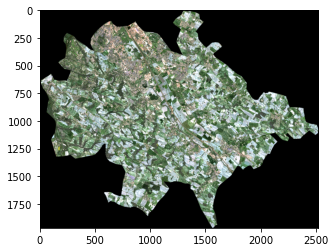

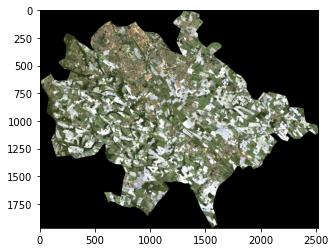

In [31]:
img1_arr = tiff.imread(img1_path_inpaint)
plt.figure(13)
plt.imshow(img1_arr[...,0:3])

img2_arr = tiff.imread(img2_path_inpaint)
plt.figure(14)
plt.imshow(img2_arr[...,0:3])

## 🌴 Analyse 4 : méthode de segmentation en `superpixels`
---

**Objectif :** L'objectif est de regrouper des pixels afin de créer des groupes de pixels de même nature. Le second objectif sera ensuite d'appliquer des modèles non supervisés afin de détecter des parcelles agricoles des différentes cultures.

Effectuons une segmentation en superpixels sur la première image
en utilisant l'algorithme de Felzenszwalb implémenté dans la bibliothèque Scikit-image

Documentation : https://github.com/RaphaelGervillie/Superpixel

**Les paramètres :**

- `min_size` : nombre minimun de pixels dans un regroupement de pixels
- `sigma` : Width (standard deviation) of Gaussian kernel used in preprocessing.
- `scale` : Free parameter. Higher means larger clusters.

Documentation : https://scikit-image.org/docs/stable/api/skimage.segmentation.html#skimage.segmentation.felzenszwalb

In [32]:
segments_fz = felzenszwalb(img1_arr, scale=100, sigma=0.5, min_size=50) # paramètres par défaut

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: RuntimeWarning: Got image with third dimension of 4. This image will be interpreted as a multichannel 2d image, which may not be intended.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [33]:
print('Shape of inpainted image :', img1_arr.shape)
print('Shape of superpixel segmentation result :', segments_fz.shape, '\n')
print('Unique elements of inpainted image :', len(np.unique(img1_arr)))
print('Unique elements of superpixel segmentation result :', len(np.unique(segments_fz)))

Shape of inpainted image : (1967, 2520, 4)
Shape of superpixel segmentation result : (1967, 2520) 

Unique elements of inpainted image : 10218
Unique elements of superpixel segmentation result : 11507


### Visualisation du résultat
Visualiser les résultats de la segmentation à l'aide de matplotlib en superposant les segments sur l'image originale.

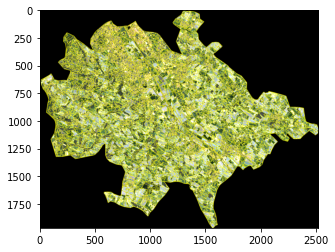

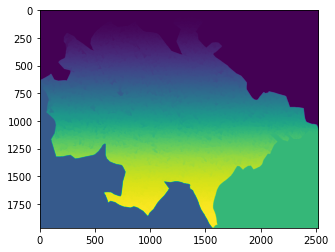

In [34]:
plt.figure(15)
plt.imshow(mark_boundaries(img1_arr[...,0:3], segments_fz))

plt.figure(16)
plt.imshow(segments_fz) # chaque pixel a un id est identifie

### Extraction de caractéristique pour chaque segment
Nous allons extraire des caractéristiques pour chaque segment. Ici, nous utiliserons la moyenne et l'écart-type des pixels à l'intérieur de chaque segment.

---

🚨 ❗ Cette étape prend environ 5 minutes ❗

---

**Définitions :**

- `segVal` : l'id du superpixel
- `i` : l'index du superpixel

In [35]:
features = {}
for (i, segVal) in enumerate(np.unique(segments_fz)):
    features[i] = {}
    print('[x] inspecting segment %d' % (i))
    values = img1_arr[segments_fz==segVal]
    features[i]['mean'] = np.mean(values,axis=0)
    features[i]['std'] = np.std(values,axis=0)

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
[x] inspecting segment 6507
[x] inspecting segment 6508
[x] inspecting segment 6509
[x] inspecting segment 6510
[x] inspecting segment 6511
[x] inspecting segment 6512
[x] inspecting segment 6513
[x] inspecting segment 6514
[x] inspecting segment 6515
[x] inspecting segment 6516
[x] inspecting segment 6517
[x] inspecting segment 6518
[x] inspecting segment 6519
[x] inspecting segment 6520
[x] inspecting segment 6521
[x] inspecting segment 6522
[x] inspecting segment 6523
[x] inspecting segment 6524
[x] inspecting segment 6525
[x] inspecting segment 6526
[x] inspecting segment 6527
[x] inspecting segment 6528
[x] inspecting segment 6529
[x] inspecting segment 6530
[x] inspecting segment 6531
[x] inspecting segment 6532
[x] inspecting segment 6533
[x] inspecting segment 6534
[x] inspecting segment 6535
[x] inspecting segment 6536
[x] inspecting segment 6537
[x] inspecting segment 6538
[x] inspecting segment 653

In [36]:
print('Number of superpixel segments :', len(np.unique(segments_fz)))
print('Number of observations in features vector :', len(features))

Number of superpixel segments : 11507
Number of observations in features vector : 11507


In [37]:
for i in range(5):
  print(features[i])

{'mean': array([0., 0., 0., 0.], dtype=float32), 'std': array([0., 0., 0., 0.], dtype=float32)}
{'mean': array([0.00072588, 0.00080417, 0.00062829, 0.00072588], dtype=float32), 'std': array([0.01343613, 0.01458005, 0.01146083, 0.01343613], dtype=float32)}
{'mean': array([0.45916128, 0.54582286, 0.40448806, 0.45916128], dtype=float32), 'std': array([0.19919707, 0.1592998 , 0.20831299, 0.19919707], dtype=float32)}
{'mean': array([0., 0., 0., 0.], dtype=float32), 'std': array([0., 0., 0., 0.], dtype=float32)}
{'mean': array([8.4731764e-05, 1.3138182e-04, 7.3852039e-05, 8.4731764e-05],
      dtype=float32), 'std': array([0.00374897, 0.00579249, 0.00331159, 0.00374897], dtype=float32)}


### Création d'une matrice d'entrée pour un clustering

**Les étapes :** 

1. Créez deux tableaux, l'un associé à la moyenne et l'autre à l'écart type.
2. Inspecter l'histogramme des caractéristiques de la moyenne et de l'écart type.
3. Créer une matrice de caractéristiques où nous concaténons les tableaux de moyenne et de std.
4. Entraîner un modèle de clustering `Mini-batch Kmeans` : nous utiliserons le Mini-batch Kmeans pour le clustering car nous avons un grand ensemble de données.
5. Attribuer les étiquettes Kmeans aux segments.
6. Visualiser le résultat du clustering.
7. Sauvegarder les résultats en tant que Geotiff.

**1. Créez deux tableaux, l'un associé à la moyenne et l'autre à l'écart type.**

**2. Inspecter l'histogramme des caractéristiques de la moyenne et de l'écart type.**

(array([[1.670e+02, 1.349e+03, 2.938e+03, 2.622e+03, 1.789e+03, 1.275e+03,
         9.200e+02, 3.590e+02, 7.400e+01, 1.400e+01],
        [2.530e+02, 1.750e+03, 3.533e+03, 2.994e+03, 1.827e+03, 8.980e+02,
         2.180e+02, 3.100e+01, 2.000e+00, 1.000e+00],
        [2.710e+02, 1.441e+03, 2.794e+03, 2.699e+03, 2.059e+03, 1.415e+03,
         6.430e+02, 1.530e+02, 2.800e+01, 4.000e+00],
        [1.670e+02, 1.349e+03, 2.938e+03, 2.622e+03, 1.789e+03, 1.275e+03,
         9.200e+02, 3.590e+02, 7.400e+01, 1.400e+01]]),
 array([0.        , 0.03012888, 0.06025776, 0.09038664, 0.12051553,
        0.1506444 , 0.18077329, 0.21090217, 0.24103105, 0.27115995,
        0.3012888 ], dtype=float32),
 <a list of 4 Lists of Patches objects>)

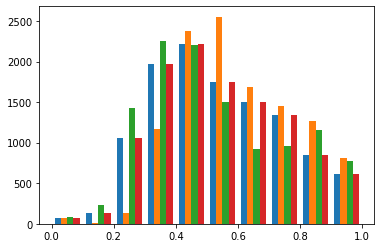

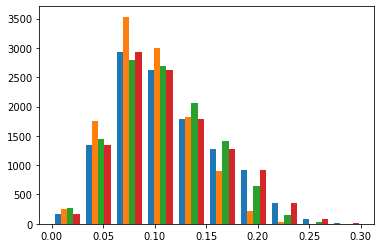

In [38]:
mean_arr = [features[x]['mean'] for x  in range (len(features))]
mean_arr = np.array(mean_arr)

std_arr = [features[x]['std'] for x  in range (len(features))]
std_arr = np.array(std_arr)

plt.figure(17)
plt.hist(mean_arr)

plt.figure(18)
plt.hist(std_arr)

**3. Créer une matrice de caractéristiques où nous concaténons les tableaux de moyenne et de std.**

In [39]:
feature_arr = np.zeros((len(features),8),dtype=np.float32)
feature_arr[:,0:4] = np.copy(mean_arr)
feature_arr[:,4:] = np.copy(std_arr)

print(feature_arr.shape, '\n')
print(feature_arr)

(11507, 8) 

[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [7.25883234e-04 8.04169395e-04 6.28293725e-04 ... 1.45800505e-02
  1.14608314e-02 1.34361293e-02]
 [4.59161282e-01 5.45822859e-01 4.04488057e-01 ... 1.59299806e-01
  2.08312988e-01 1.99197069e-01]
 ...
 [7.29091167e-01 7.80284345e-01 8.34182739e-01 ... 5.45296557e-02
  7.57610425e-02 6.33048043e-02]
 [4.34085816e-01 5.81069529e-01 4.24072057e-01 ... 7.07293972e-02
  7.86270425e-02 7.93680102e-02]
 [7.32090056e-01 8.15141559e-01 8.43676150e-01 ... 1.03633195e-01
  1.30269453e-01 1.09109752e-01]]


**4. Entraîner un modèle de clustering `Mini-batch Kmeans`.**

In [40]:
kmeans = MiniBatchKMeans(n_clusters=6, random_state=0, batch_size=100)
number_patches = int(len(features)/100)
print(number_patches)
for p in range(number_patches):
    if p!=number_patches-1:
         kmeans = kmeans.partial_fit(feature_arr[p*100:(p+1)*100,:])
    else:
         kmean = kmeans.partial_fit(feature_arr[p*100:,:])

labels = kmeans.predict(feature_arr)

115


**5. Attribuer les étiquettes Kmeans aux segments.**

In [41]:
label_arr = np.zeros_like(segments_fz)
for (i, segVal) in enumerate(np.unique(segments_fz)):
    print('[x] filling segment %d' % (i))
    label_arr[segments_fz==segVal] = labels[i]

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
[x] filling segment 6507
[x] filling segment 6508
[x] filling segment 6509
[x] filling segment 6510
[x] filling segment 6511
[x] filling segment 6512
[x] filling segment 6513
[x] filling segment 6514
[x] filling segment 6515
[x] filling segment 6516
[x] filling segment 6517
[x] filling segment 6518
[x] filling segment 6519
[x] filling segment 6520
[x] filling segment 6521
[x] filling segment 6522
[x] filling segment 6523
[x] filling segment 6524
[x] filling segment 6525
[x] filling segment 6526
[x] filling segment 6527
[x] filling segment 6528
[x] filling segment 6529
[x] filling segment 6530
[x] filling segment 6531
[x] filling segment 6532
[x] filling segment 6533
[x] filling segment 6534
[x] filling segment 6535
[x] filling segment 6536
[x] filling segment 6537
[x] filling segment 6538
[x] filling segment 6539
[x] filling segment 6540
[x] filling segment 6541
[x] filling segment 6542
[x] filling segment 65

**6. Visualiser le résultat du clustering.**

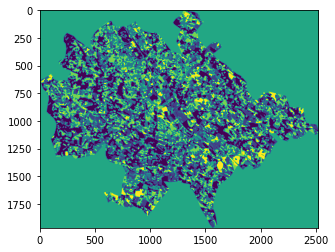

In [42]:
plt.figure(19)
plt.imshow(label_arr)

**7. Sauvegarder les résultats en tant que Geotiff.**

In [ ]:
label_arr[img1_arr[...,0]==0] = -1 # convert nan to -1

# output_path = './USE_CASE_2/image_dataset/superpixel_segmentation'
# create_directory(output_path)
# output_filename = join(output_path,'superpixel_seg_img1.tif')
# dataset = gdal.Open(img1_path)
#array2raster(output_filename, dataset, label_arr, 'Float32')

### Appliquer le modèle à la seconde image

**Objectif :** A partir de plusieurs dates (ici seulement 2 dates), extraire les caractéristiques de chaque pixel, puis à partir des superpixels identifier des groupes de champs. L'ojectif est bien de détecter des parcelles de champs de culture différente à l'aide de plusieurs dates d'observation.

**Les étapes :** 

1. Utilisez les segments pour extraire les caractéristiques de la seconde image.
2. Créer une matrice de caractéristiques qui contient les caractéristiques de la première et de la seconde image.
3. Appliquer le clustering à la matrice globale enrichie des caractéristiques.
4. Visualiser le résultat du clustring sur l'image.

**1. Utilisez les segments pour extraire les caractéristiques de la seconde image.**

---

🚨 ❗ Cette étape prend environ 5 minutes ❗

---

In [43]:
img2_arr = tiff.imread(img2_path_inpaint)
features = {}
for (i, segVal) in enumerate(np.unique(segments_fz)):
    features[i] = {}
    print('[x] inspecting segment %d' % (i))
    values = img2_arr[segments_fz==segVal]
    features[i]['mean'] = np.mean(values,axis=0)
    features[i]['std'] = np.std(values,axis=0)

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
[x] inspecting segment 6507
[x] inspecting segment 6508
[x] inspecting segment 6509
[x] inspecting segment 6510
[x] inspecting segment 6511
[x] inspecting segment 6512
[x] inspecting segment 6513
[x] inspecting segment 6514
[x] inspecting segment 6515
[x] inspecting segment 6516
[x] inspecting segment 6517
[x] inspecting segment 6518
[x] inspecting segment 6519
[x] inspecting segment 6520
[x] inspecting segment 6521
[x] inspecting segment 6522
[x] inspecting segment 6523
[x] inspecting segment 6524
[x] inspecting segment 6525
[x] inspecting segment 6526
[x] inspecting segment 6527
[x] inspecting segment 6528
[x] inspecting segment 6529
[x] inspecting segment 6530
[x] inspecting segment 6531
[x] inspecting segment 6532
[x] inspecting segment 6533
[x] inspecting segment 6534
[x] inspecting segment 6535
[x] inspecting segment 6536
[x] inspecting segment 6537
[x] inspecting segment 6538
[x] inspecting segment 653

**2. Créer une matrice de caractéristiques qui contient les caractéristiques de la première et de la seconde image.**

In [44]:
mean_arr = [features[x]['mean'] for x  in range (len(features))]
mean_arr = np.array(mean_arr)
std_arr = [features[x]['std'] for x  in range (len(features))]
std_arr = np.array(std_arr)
feature_arr2 = np.zeros((len(features),8),dtype=np.float32)
feature_arr2[:,0:4] = np.copy(mean_arr)
feature_arr2[:,4:] = np.copy(std_arr)

global_features = np.zeros((len(features),16),dtype=np.float32)
global_features[:,0:8] = np.copy(feature_arr)
global_features[:,8:] = np.copy(feature_arr2)

print('Shape of image 1 features :', feature_arr.shape)
print('Shape of image 2 features :', feature_arr2.shape)
print('Shape of global features :', global_features.shape)

Shape of image 1 features : (11507, 8)
Shape of image 2 features : (11507, 8)
Shape of global features : (11507, 16)


**3. Appliquer le clustering à la matrice globale enrichie des caractéristiques.**

In [45]:
kmeans = MiniBatchKMeans(n_clusters=6, random_state=0, batch_size=100)
number_patches = int(len(features)/100)
print(number_patches)
for p in range(number_patches):
    if p!=number_patches-1:
         kmeans = kmeans.partial_fit(global_features[p*100:(p+1)*100,:])
    else:
         kmean = kmeans.partial_fit(global_features[p*100:,:])

115


In [47]:
labels = kmeans.predict(global_features)
label_arr2 = np.zeros_like(segments_fz)
for (i, segVal) in enumerate(np.unique(segments_fz)):
    print('[x] filling segment %d' % (i))
    label_arr2[segments_fz==segVal] = labels[i]

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
[x] filling segment 6507
[x] filling segment 6508
[x] filling segment 6509
[x] filling segment 6510
[x] filling segment 6511
[x] filling segment 6512
[x] filling segment 6513
[x] filling segment 6514
[x] filling segment 6515
[x] filling segment 6516
[x] filling segment 6517
[x] filling segment 6518
[x] filling segment 6519
[x] filling segment 6520
[x] filling segment 6521
[x] filling segment 6522
[x] filling segment 6523
[x] filling segment 6524
[x] filling segment 6525
[x] filling segment 6526
[x] filling segment 6527
[x] filling segment 6528
[x] filling segment 6529
[x] filling segment 6530
[x] filling segment 6531
[x] filling segment 6532
[x] filling segment 6533
[x] filling segment 6534
[x] filling segment 6535
[x] filling segment 6536
[x] filling segment 6537
[x] filling segment 6538
[x] filling segment 6539
[x] filling segment 6540
[x] filling segment 6541
[x] filling segment 6542
[x] filling segment 65

**4. Visualiser le résultat du clustring sur l'image.**

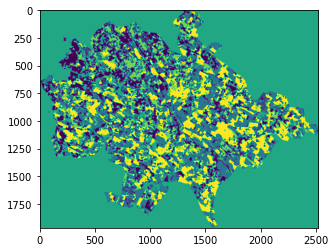

In [48]:
plt.figure(20)
plt.imshow(label_arr2)

In [ ]:
label_arr2[img1_arr[...,0]==0] = -1 # convert nan to -1
# output_path = './USE_CASE_2/image_dataset/superpixel_segmentation'
#create_directory(output_path)
# output_filename = join(output_path,'superpixel_seg_img1_img2.tif')
# dataset = gdal.Open(img1_path)
#array2raster(output_filename,dataset,label_arr2,'Float32')

# TP 2 (exercice) : Classification supervisée des pixels

**Objectif :** 

L'objectif est de créer un modèle de classification supervisée pour classifier chaque pixel dans 5 classes différents représentant une nature de sol différent.


**Questions / Etapes :**

1. Lire les données des images et des labels associés.
2. Supprimer les pixels associés à du blanc (ie supprimer lorsque label=0).
3. Création de la matrice où chaque ligne contient les valeurs des pixels de chaque bande des 2 images : pour chaque label on associe les valeurs des pixels sur chaque bande pour chaque image. On concatène les informations des pixels des 2 images.
4. On mélange la matrice afin d'équilibrer les ensembles d'apprentissage et de test : pour chaque arbre il faut prendre un sample de chaque classe, il faut pour cela mélanger les données.
5. Diviser la matrice en deux sous-ensembles (train, test). Choisir le pourcentage de données dans chaque sous-ensemble.
6. Définir la grille de recherche des hyperparamètres.
7. Instancier un classifieur RandomForest (`RandomForestClassifier`) et choisir entre : 

    a. Random Search Method (`RandomizedSearchCV`)

    b. Grid Search Method (`GridSearchCV`)

    c. Quelle est la différence entre `RandomizedSearchCV` et `GridSearchCV` ?

In [ ]:
# Lecture des données
img1_path = './USE_CASE_2/image_dataset/training_data/inpainted_img1.tif'
img2_path = './USE_CASE_2/image_dataset/training_data/inpainted_img2.tif'
label_path = './USE_CASE_2/image_dataset/training_data/sicoval_training.tif'

img1 = tiff.imread(img1_path)
img2 = tiff.imread(img2_path)
label_img = tiff.imread(label_path)

# A vous de jouer !

### Corrections

#### Correction n°1

**Correction n°1 : avec la méthode `Random search`** 

Les étapes suivies : 

1. Lire les données des images et des labels associés.
2. Supprimer les pixels associés à du blanc (ie: label=0).
3. Création de la matrice où chaque ligne contient les valeurs des pixels de chaque bande des 2 images : pour chaque label on associe les valeurs des pixels sur chaque bande pour chaque image.
4. On mélange la matrice afin d'équilibrer les ensembles d'apprentissage et de test : pour chaque arbre il faut prendre un sample de chaque classe, il faut pour ca melanger les donnees.
5. Diviser la matrice en deux sous-ensembles (train, test). Choisir le pourcentage de données dans chaque sous-ensemble.
6. Définir la grille de recherche des hyperparamètres.
7. Instancier un classifieur RandomForest (`RandomForestClassifier`) et un  random search method (`RandomizedSearchCV`).

In [5]:
def shuffle_two_arrays(img, msk):
    rng_state = np.random.get_state()
    np.random.shuffle(img)
    np.random.set_state(rng_state)
    np.random.shuffle(msk)
    return img, msk

def evaluate(model, X_test, y_test):
    yhat = model.predict(X_test)
    accuracy = accuracy_score(y_test,yhat)
    f_score = f1_score(y_test,yhat,average='weighted')
    p_score = precision_score(y_test,yhat,average='weighted')
    r_score = recall_score(y_test,yhat,average='weighted')
    confusion_mat = confusion_matrix(y_test,yhat)

    print ('accuracy',accuracy)
    print ('f1 score',f_score)
    print ('precision',p_score)
    print ('recall',r_score)
    print ('confusion matrix',confusion_mat)
    return accuracy,f_score,p_score,confusion_mat

def array2raster(newRasterfn, dataset, array, dtype):
    cols = array.shape[1]
    rows = array.shape[0]
    originX, pixelWidth, b, originY, d, pixelHeight = dataset.GetGeoTransform()
    driver = gdal.GetDriverByName('GTiff')
    GDT_dtype = gdal.GDT_Unknown
    if dtype == "Byte":
        GDT_dtype = gdal.GDT_Byte
    elif dtype == "Float32":
        GDT_dtype = gdal.GDT_Float32
    else:
        print("Not supported data type.")
    if array.ndim == 2:
        band_num = 1
    else:
        band_num = array.shape[2]

    outRaster = driver.Create(newRasterfn, cols, rows, band_num, GDT_dtype)
    outRaster.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))
    for b in range(band_num):
        outband = outRaster.GetRasterBand(b + 1)
        if band_num == 1:
            outband.WriteArray(array)
        else:
            outband.WriteArray(array[:,:,b])

    prj=dataset.GetProjection()
    outRasterSRS = osr.SpatialReference(wkt=prj)
    outRaster.SetProjection(outRasterSRS.ExportToWkt())
    outband.FlushCache()

In [6]:
img1_path = './USE_CASE_2/image_dataset/training_data/inpainted_img1.tif'
img2_path = './USE_CASE_2/image_dataset/training_data/inpainted_img2.tif'
label_path = './USE_CASE_2/image_dataset/training_data/sicoval_training.tif'
output_path = './USE_CASE_2/image_dataset/pixel_classification'
#create_directory(output_path)

Shape of image : (1967, 2520, 4)
Shape of label image : (1967, 2520) 



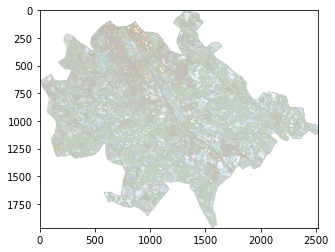

(7509, 4)
(7509, 4)
(7509,) 

[[0.08523908 0.10465116 0.02756339 ... 0.21672828 0.13848117 0.26196808]
 [0.09043659 0.10259918 0.03362734 ... 0.21441774 0.13178048 0.25664893]
 [0.09147609 0.0868673  0.02646086 ... 0.22227357 0.15698788 0.27726063]
 ...
 [0.68087316 0.54103965 0.44873208 ... 0.45286506 0.36439055 0.5831117 ]
 [0.62889814 0.50889194 0.46196252 ... 0.3909427  0.27536693 0.40625   ]
 [0.69542617 0.5875513  0.47464168 ... 0.5304991  0.34077856 0.54587764]] 
 (7509, 8)
[2 2 2 ... 1 1 1]
[[0.08523908 0.10465116 0.02756339 ... 0.21672828 0.13848117 0.26196808]
 [0.09043659 0.10259918 0.03362734 ... 0.21441774 0.13178048 0.25664893]
 [0.09147609 0.0868673  0.02646086 ... 0.22227357 0.15698788 0.27726063]
 ...
 [0.68087316 0.54103965 0.44873208 ... 0.45286506 0.36439055 0.5831117 ]
 [0.62889814 0.50889194 0.46196252 ... 0.3909427  0.27536693 0.40625   ]
 [0.69542617 0.5875513  0.47464168 ... 0.5304991  0.34077856 0.54587764]]
[1 1 1 ... 5 1 1]
[[0.5966736  0.5827633  0.52205074

In [7]:
# 1. Lire les données
img1 = tiff.imread(img1_path)
img2 = tiff.imread(img2_path)
label_img = tiff.imread(label_path)
print('Shape of image :', img1.shape)
print('Shape of label image :', label_img.shape, '\n')
plt.figure(1)
plt.imshow(img1)
plt.show()

# 2. Supprimer les pixels associés à du blanc.
pixels_img1 = img1[label_img>0]
pixels_img2 = img2[label_img>0]
labels = label_img[label_img>0] # vectorisation
print(pixels_img1.shape)
print(pixels_img2.shape)
print(labels.shape, '\n')

# 3. Création de la matrice d'entrée
pixels = np.zeros((labels.shape[0],8), dtype=np.float32)
pixels[:,0:4] = np.copy(pixels_img1)
pixels[:,4:] = np.copy(pixels_img2)
print(pixels, '\n', pixels.shape)

# 4. Mélanger les données d'entrées
print(labels)
print(pixels)
pixels,labels = shuffle_two_arrays(pixels,labels) 
print(labels)
print(pixels)

# 5. Diviser le jeu de données (train, test)
X_train, X_test, y_train, y_test = train_test_split(pixels, labels, test_size=0.25, random_state=1)
print('\n', 'X train shape', X_train.shape)
print('y train shape', y_train.shape)
print('unique labels train', np.unique(y_train,return_counts=True))
print('X test shape', X_test.shape)
print('y test shape', y_test.shape)
print('unique labels test', np.unique(y_test,return_counts=True), '\n')

# 6. Définir la grille de recherche des hyperparamètres
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)] # number of trees in random forest
max_features = ['auto', 'sqrt'] # number of features to consider at every split
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)] # maximum number of levels in tree
max_depth.append(None)
min_samples_split = [2, 5, 10] # minimum number of samples required to split a node
min_samples_leaf = [1, 2, 4] # minimum number of samples required at each leaf node
bootstrap = [True, False]# method of selecting samples for training each tree
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap} # create the random grid
pp = pprint.PrettyPrinter()
pp.pprint(random_grid)

# 7. Instancier un classifieur RandomForest et un objet RandomSearchCV
clf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = clf, param_distributions = random_grid,
                               n_iter = 50, cv = 3, verbose=2, random_state=42, n_jobs = -1)

---

🚨 ❗ Cette étape prend environ 15 minutes ❗

---

In [96]:
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [113]:
# 8. Afficher les meilleurs paramètres et la performance du modèle
print('Best parameters :', rf_random.best_params_)
best_random = rf_random.best_estimator_
_,_,_,_ = evaluate(best_random, X_test, y_test)

# 9. Créer le meilleur modèle
base_model = RandomForestClassifier(**rf_random.best_params_)
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_test, y_test)
print('\n', base_accuracy)

Best parameters : {'n_estimators': 800, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 90, 'bootstrap': False}
accuracy 0.9861554845580405
f1 score 0.9861403530123322
precision 0.9862540180682368
recall 0.9861554845580405
confusion matrix [[695   0   4   4   0]
 [  0  76   0   0   0]
 [  0   0 281   0   0]
 [ 16   0   0 481   0]
 [  1   1   0   0 319]]
accuracy 0.9861554845580405
f1 score 0.9861403530123322
precision 0.9862540180682368
recall 0.9861554845580405
confusion matrix [[695   0   4   4   0]
 [  0  76   0   0   0]
 [  0   0 281   0   0]
 [ 16   0   0 481   0]
 [  1   1   0   0 319]]

 (0.9861554845580405, 0.9861403530123322, 0.9862540180682368, array([[695,   0,   4,   4,   0],
       [  0,  76,   0,   0,   0],
       [  0,   0, 281,   0,   0],
       [ 16,   0,   0, 481,   0],
       [  1,   1,   0,   0, 319]]))


#### Correction n°2

**Correction n°2 : avec la méthode `Grid search`** 

Les étapes suivies : 

1. Lire les données des images et des labels associés.
2. Supprimer les pixels associés à du blanc (ie: label=0).
3. Création de la matrice où chaque ligne contient les valeurs des pixels de chaque bande des 2 images : pour chaque label on associe les valeurs des pixels sur chaque bande pour chaque image.
4. On mélange la matrice afin d'équilibrer les ensembles d'apprentissage et de test : pour chaque arbre il faut prendre un sample de chaque classe, il faut pour ca melanger les donnees.
5. Diviser la matrice en deux sous-ensembles (train, test). Choisir le pourcentage de données dans chaque sous-ensemble.
6. Définir la grille de recherche des hyperparamètres.
7. Instancier un classifieur RandomForest (`RandomForestClassifier`) et un  objet GridSearchCV (`GridSearchCV`).
8. Afficher les meilleurs paramètres et la performance du modèle
9. Visualisation des arbres de décision
10. Feature importance derived from SHAP for each class
11. Visualiser les résultats en image.
12. Etape post-traitement avec filtrage.

---

🚨 ❗ Cette étape prend environ 20 minutes ❗

---

In [8]:
# 6. Définir la grille de recherche des hyperparamètres
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

# 7. Instancier un classifieur RandomForest et un objet GridSearchCV
clf = RandomForestClassifier()
grid_search = GridSearchCV(estimator = clf, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 288 candidates, totalling 864 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [80, 90, 100, 110],
                         'max_features': [2, 3], 'min_samples_leaf': [3, 4, 5],
                         'min_samples_split': [8, 10, 12],
                         'n_estimators': [100, 200, 300, 1000]},
             verbose=2)

In [9]:
# 8. Afficher les meilleurs paramètres et la performance du modèle
print('Best parameters :', grid_search.best_params_)
best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, X_test, y_test)

Best parameters : {'bootstrap': True, 'max_depth': 90, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 100}
accuracy 0.9914802981895634
f1 score 0.991474811753655
precision 0.9914771593033413
recall 0.9914802981895634
confusion matrix [[690   0   1   6   0]
 [  0  74   0   0   1]
 [  0   0 265   0   0]
 [  8   0   0 493   0]
 [  0   0   0   0 340]]


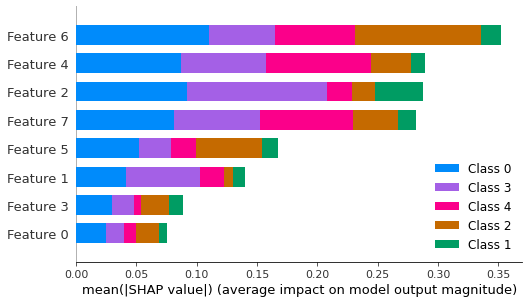

In [10]:
# 9. Visualisation des arbres de décision
explainer = shap.TreeExplainer(best_grid) # initialisation de explainer
shap_values = explainer.shap_values(X_test)

# 10. Feature importance derived from SHAP for each class
plt.figure(2)
shap.summary_plot(shap_values, X_test, plot_type="bar")

<Figure size 432x288 with 0 Axes>

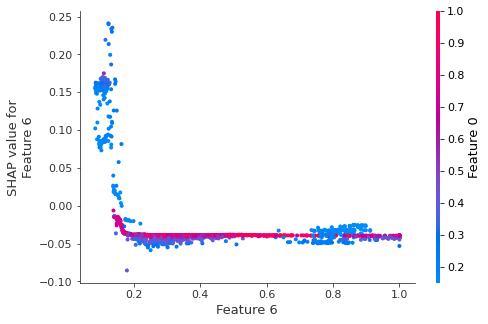

In [129]:
# 10.bis
plt.figure(3)
shap.dependence_plot('Feature 6', shap_values[4], X_test) # interaction between a specific features and other features in the dataset and the correlation with the target variable for class 0

**11. Visualiser les résultats en image.**

Il faut transformer l’image 3D en 2D. On multiplie les 2 premières coordonnées.

(4956840, 4) 
 (4956840, 4) 
 (4956840, 8) 
 (4956840,) 
 

(1967, 2520)


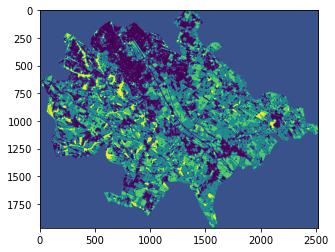

In [13]:
pixels1 = np.reshape(img1,(img1.shape[0]*img1.shape[1],img1.shape[2]))
pixels2 = np.reshape(img2,(img2.shape[0]*img2.shape[1],img2.shape[2]))
all_pixels = np.zeros((pixels1.shape[0],8),dtype=np.float32)
all_pixels[:,0:4] = np.copy(pixels1)
all_pixels[:,4:] = np.copy(pixels2)
img_labels = best_grid.predict(all_pixels)

print(pixels1.shape, '\n', pixels2.shape, '\n', all_pixels.shape, '\n', img_labels.shape, '\n', '\n')

out_arr = np.reshape(img_labels, img1.shape[:-1])
print(out_arr.shape)
plt.figure(4)
plt.imshow(out_arr)

# Save image
new_arr = np.copy(out_arr)
new_arr[img1[...,0]==0] = 0 # remettre les valeurs no_data egales a 0
dataset = gdal.Open(img1_path)
# output_fname = join(output_path,'pixel_classification.tif')
# array2raster(output_fname,dataset,new_arr,'Byte')


**12. Etape post-traitement :**

Pour traiter les pixels sel-poivre autour de pixels avec des valeurs vraiment très différents, on va appliquer un filtre `median filter`.

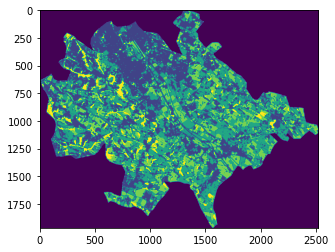

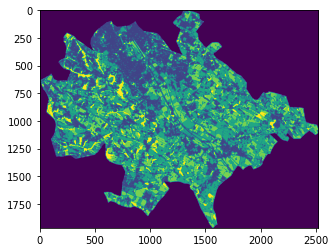

In [14]:
median_arr = cv2.medianBlur(out_arr, 3)
median_arr[img1[...,0]==0] = 0
output_fname = join(output_path,'pixel_classification_filtered.tif')
array2raster(output_fname,dataset,median_arr,'Byte')

plt.figure(5)
plt.imshow(median_arr)

plt.figure(6)
plt.imshow(new_arr)